# Uploading Dataset and Models

In [1]:
# !wget https://github.com/rajsrimanth6/ResUnet/raw/main/ResUNET_model.h5
!wget https://github.com/rajsrimanth6/ResUnet/raw/main/UNET_model.h5
!wget https://github.com/rajsrimanth6/WNET/raw/main/WNET.h5
!wget https://github.com/rajsrimanth6/WNET/raw/main/InceptionResNetV2.h5

--2024-06-07 09:44:47--  https://github.com/rajsrimanth6/ResUnet/raw/main/UNET_model.h5
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/rajsrimanth6/ResUnet/main/UNET_model.h5 [following]
--2024-06-07 09:44:47--  https://media.githubusercontent.com/media/rajsrimanth6/ResUnet/main/UNET_model.h5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203639200 (194M) [application/octet-stream]
Saving to: ‘UNET_model.h5’

UNET_model.h5       100%[===================>] 194.21M   334MB/s    in 0.6s    

2024-06-07 09:45:04 (334 MB/s) - ‘UNET_model.h5’ saved [203639200/203639200]

--2024-06-07

In [2]:
!pip install opendatasets pandas
import opendatasets as od
!wget https://raw.githubusercontent.com/rajsrimanth6/WNET/main/kaggle.json

od.download("https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation")

--2024-06-07 09:45:29--  https://raw.githubusercontent.com/rajsrimanth6/WNET/main/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      69  --.-KB/s    in 0s      

2024-06-07 09:45:29 (1.97 MB/s) - ‘kaggle.json’ saved [69/69]

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation


100%|██████████| 4.16G/4.16G [01:48<00:00, 41.3MB/s]


# Setup env

In [3]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps


# neural imaging
!pip install nilearn
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip uninstall -y imageio
!pip install imageio==2.27.0
# !pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif
# import gif_your_nifti.core as gif2nif


# ml libs
from tensorflow import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras import models
from keras.models import *
from keras import layers
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.layers.experimental import preprocessing
from keras.metrics import MeanIoU


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 27.4 MB/s eta 0:00:00
Found existing installation: imageio 2.31.6
Uninstalling imageio-2.31.6:
  Successfully uninstalled imageio-2.31.6
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 14.0 MB/s eta 0:00:00


In [4]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

TRAIN_DATASET_PATH = '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '/content/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

# Image data descriptions

All BraTS multimodal scans are available as  NIfTI files (.nii.gz) -> commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings
1. **T1**: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.
2. **T1c**: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
3. **T2**: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
4. **FLAIR**: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

Data were acquired with different clinical protocols and various scanners from multiple (n=19) institutions.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.



## Data Visualization

Text(0.5, 1.0, 'Mask')

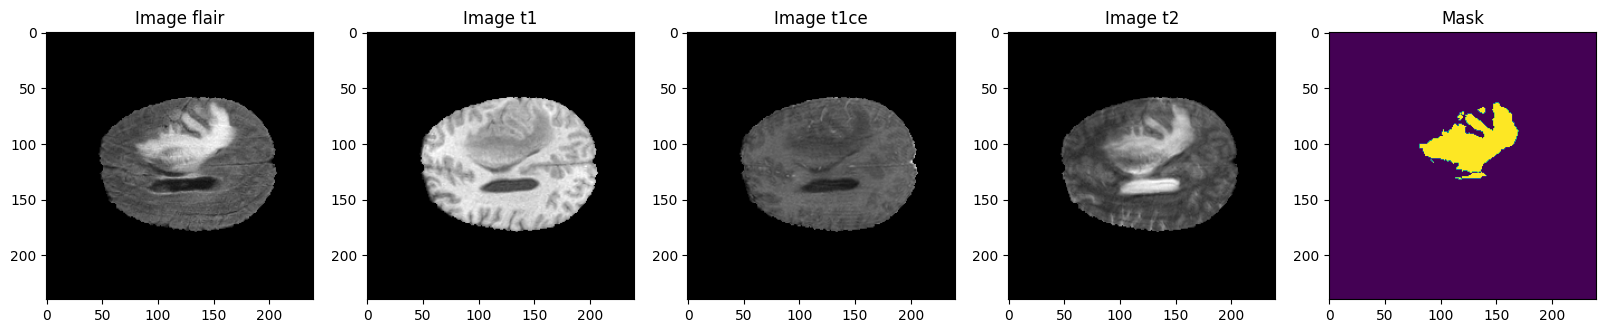

In [5]:
TRAIN_DATASET_PATH = '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '/content/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

**Show whole nifti data -> print each slice from 3d data**

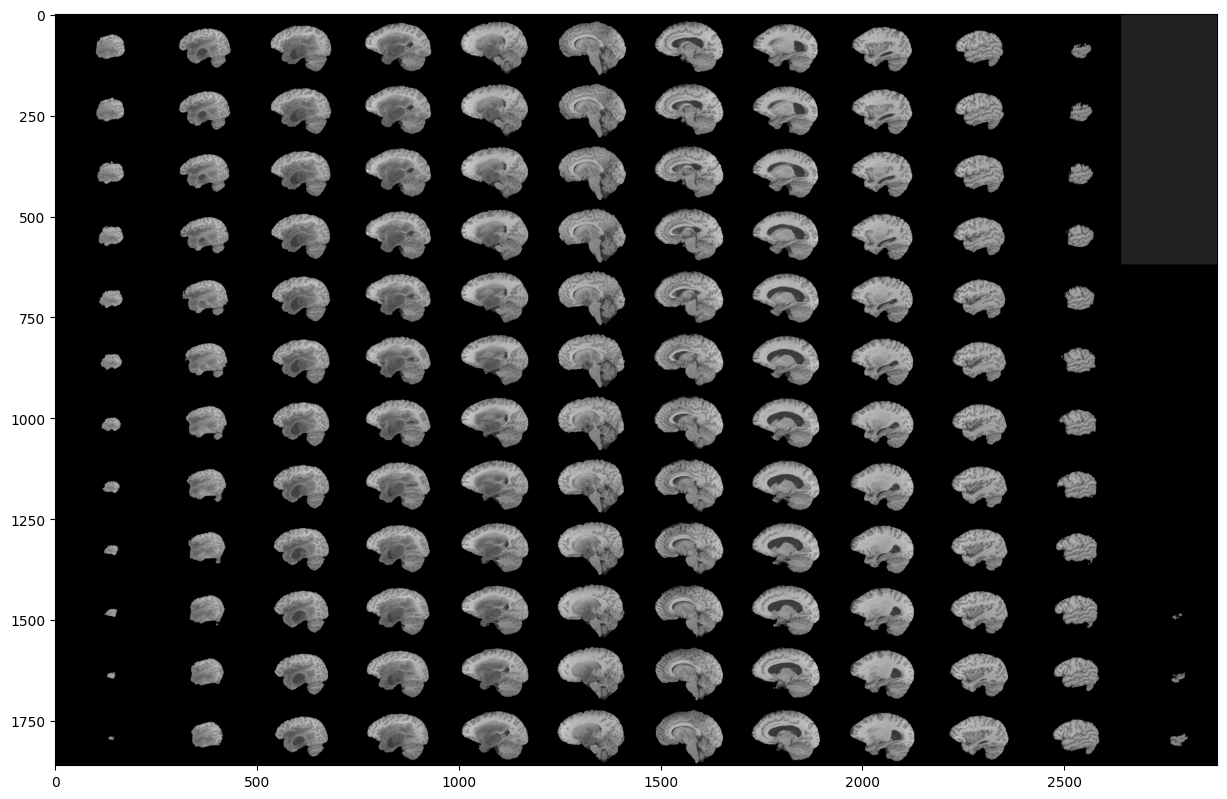

In [6]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

**Show segment of tumor for each above slice**

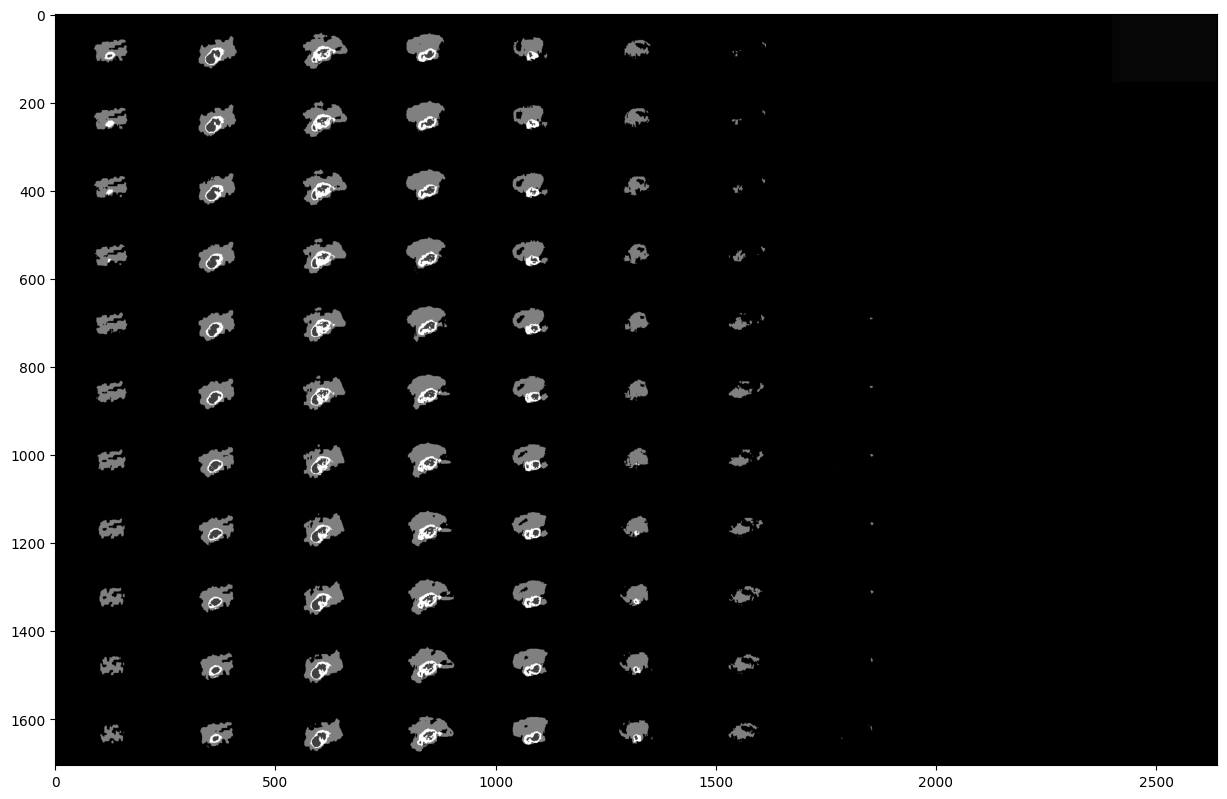

In [7]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

**Show segments of tumor using different effects**

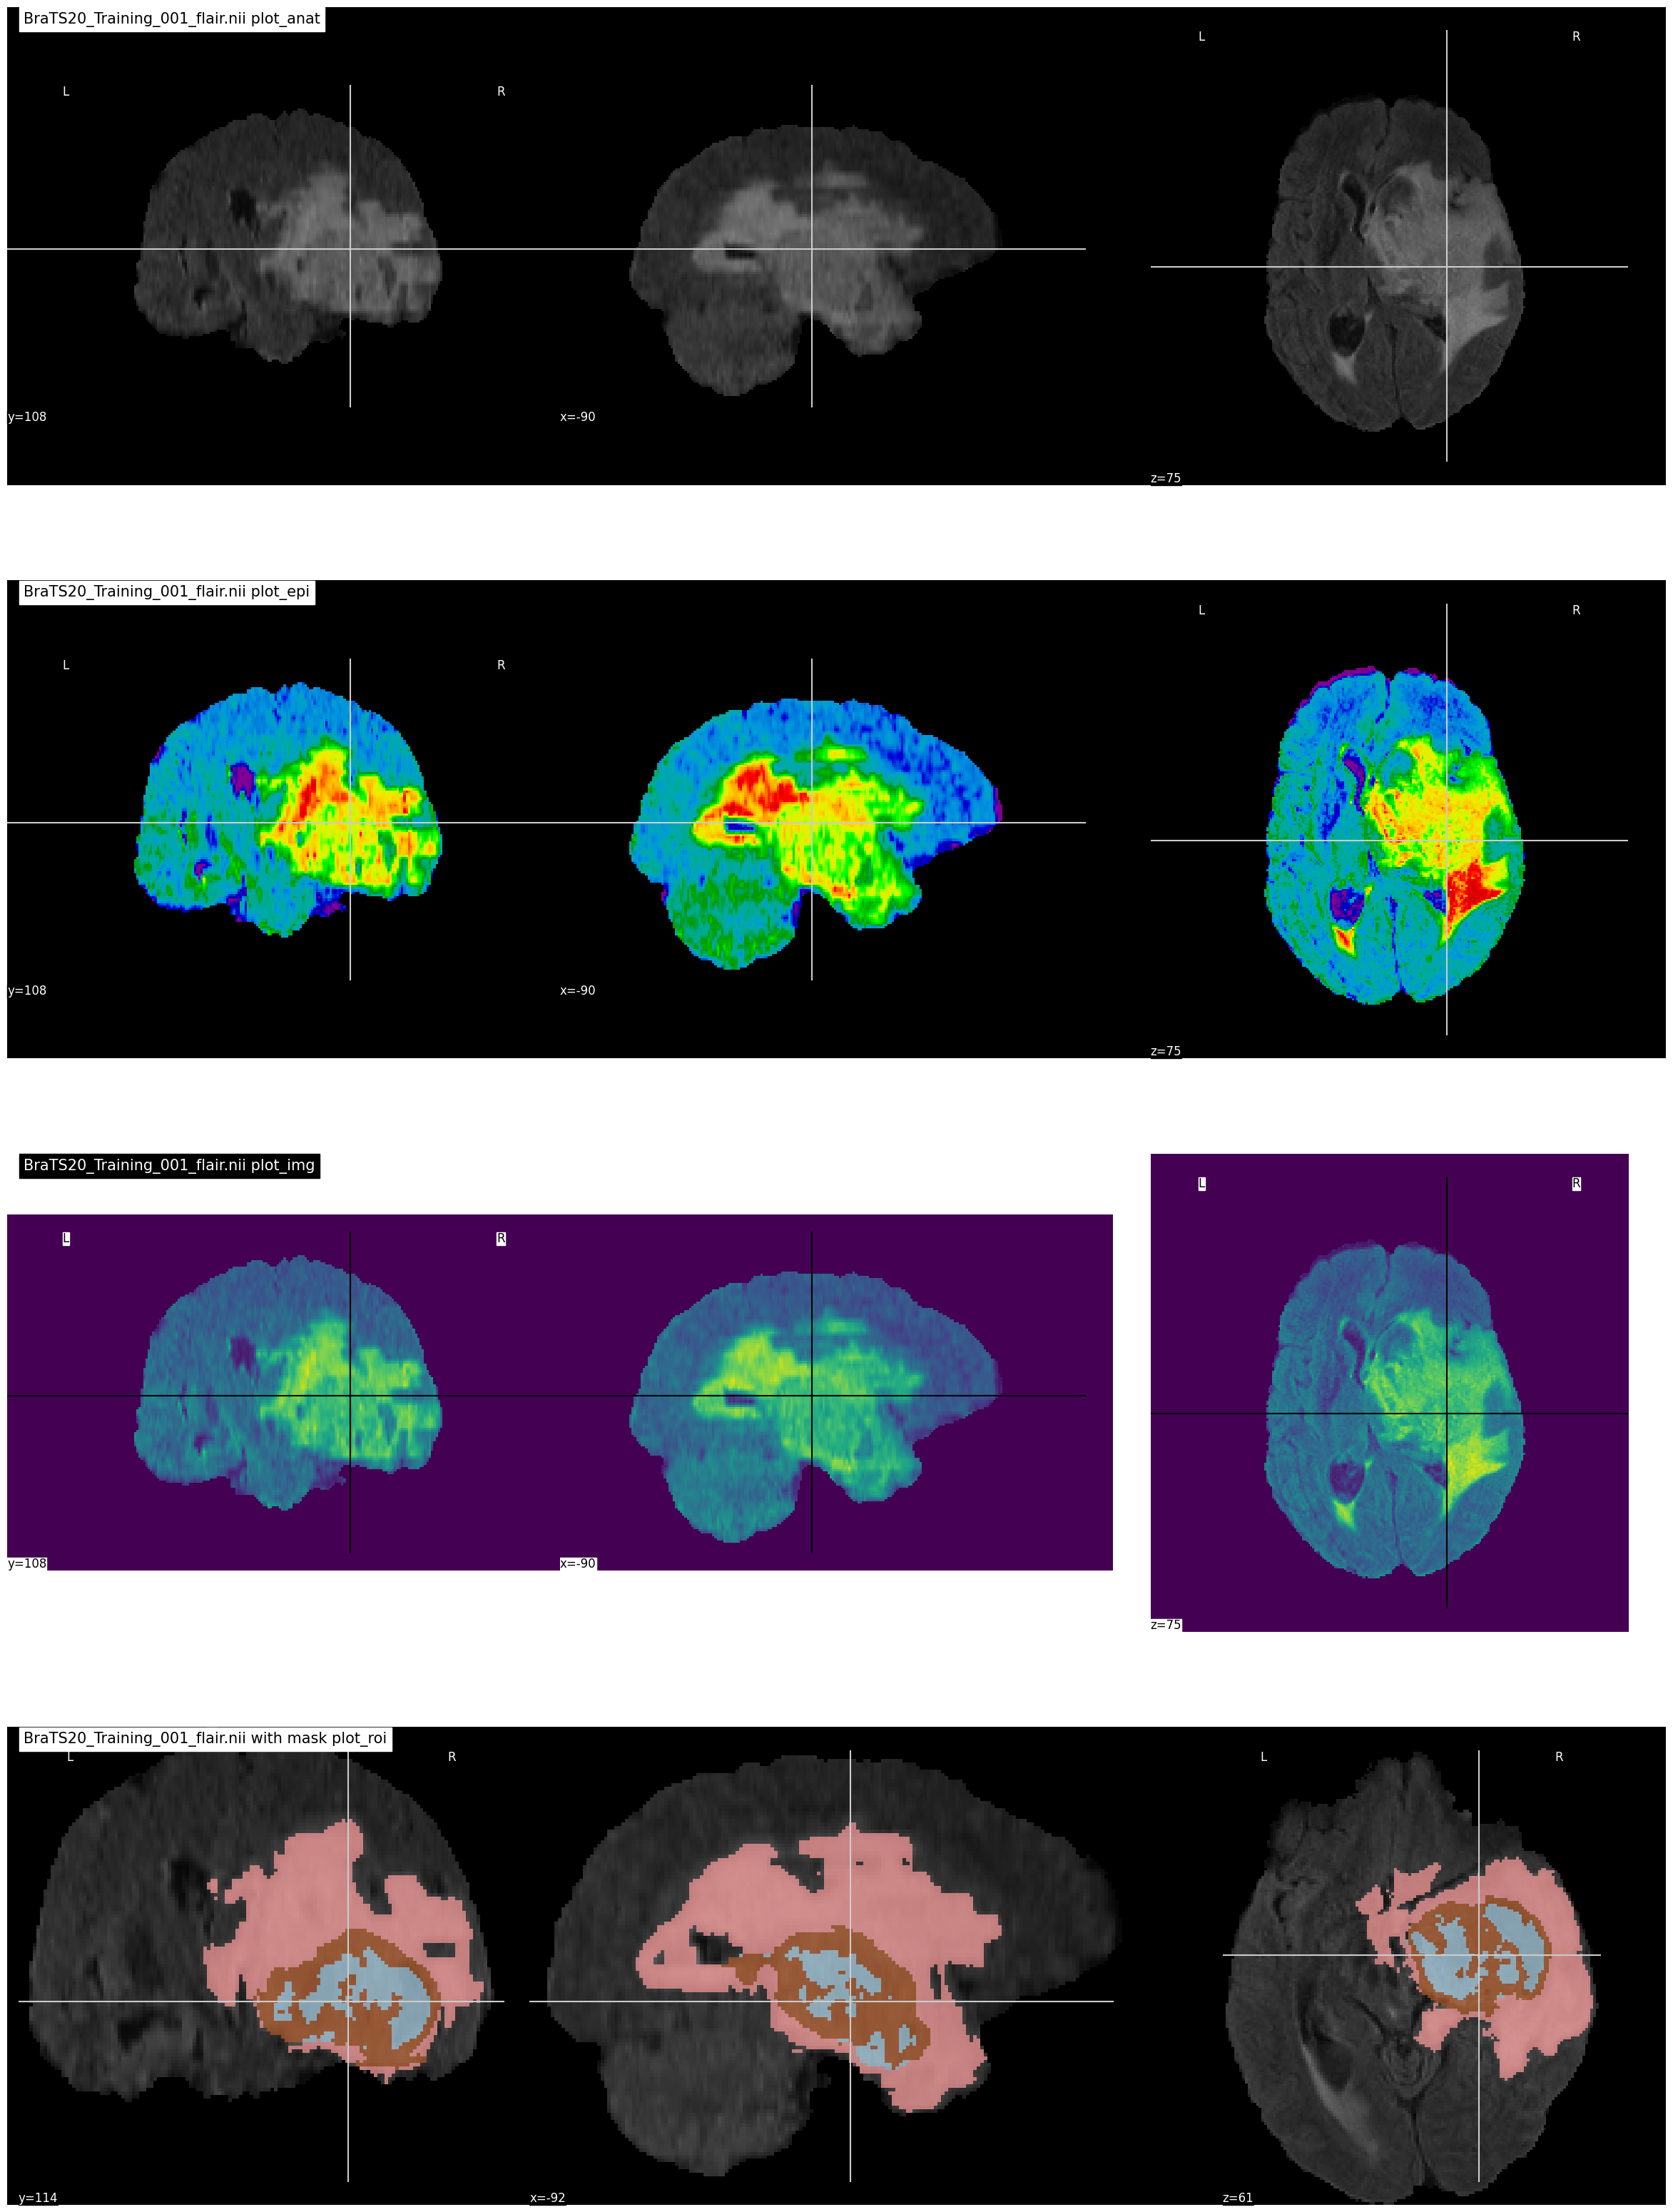

In [8]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask,
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg,
               axes=axes[3], cmap='Paired')

plt.show()

## Loss Functions

In [9]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


# Computing Recall
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (actual_positives + K.epsilon())


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def generate_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()


In [10]:
IMG_SIZE=128

### Model building

#Unet

In [11]:
# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    outputs = Conv2D(4, (1,1), activation = 'softmax')(conv)

    model = Model(inputs, outputs, name="U-Net")
    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )
    return model

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model_unet = build_unet(input_layer, 'he_normal', 0.2)


In [12]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape = (128, 128, 3) , n = 3 ,  lr = 0.0001 ):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    resnet50.layers[0]._name  = "input_1"

    resnet50._name = "Resnet50"

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output
    s2 = resnet50.get_layer("conv1_relu").output
    s3 = resnet50.get_layer("conv2_block3_out").output
    s4 = resnet50.get_layer("conv3_block4_out").output

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(n, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr) ,loss = "categorical_crossentropy" , metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])
    return model

model_resnet_unet = build_resnet50_unet()

94765736/94765736 [==============================] - 3s 0us/step


#WNet

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Dropout, concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model

# Define a single U-Net model
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool)
    conv = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(drop5))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)

    up = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv9))
    merge = concatenate([conv1, up], axis=3)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)

    outputs = Conv2D(4, (1, 1), activation='softmax')(conv)

    return Model(inputs, outputs)

# Define the WNet model by stacking two U-Nets
def build_wnet(input_shape=(128, 128, 2), ker_init='he_normal', dropout=0.2):
    inputs = Input(input_shape)

    # First U-Net
    unet1 = build_unet(inputs, ker_init, dropout)
    outputs1 = unet1(inputs)

    # Second U-Net
    unet2 = build_unet(outputs1, ker_init, dropout)
    outputs2 = unet2(outputs1)

    model = Model(inputs, outputs2, name="W-Net")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])
    return model

# Build the WNet model
wnet_model = build_wnet()

# Print model summary
wnet_model.summary()

Model: "W-Net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 2)]     0         
                                                                 
 model (Functional)          (None, 128, 128, 4)       7759908   
                                                                 
 model_1 (Functional)        (None, 128, 128, 4)       7760484   
                                                                 
Total params: 15520392 (59.21 MB)
Trainable params: 15520392 (59.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
# plot_model(model_unet,
#            show_shapes = True,
#            show_dtype=False,
#            show_layer_names = True,
#            rankdir = 'TB',
#            expand_nested = False,
#            dpi = 70)

# Load data
Loading all data into memory is not a good idea since the data are too big to fit in.
So we will create dataGenerators - load data on the fly as explained [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [16]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)

**Override Keras sequence DataGenerator class**

In [17]:
IMG_SIZE = 128

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids) # (100, 128, 128, 2)

**Number of data used**
for training / testing / validation

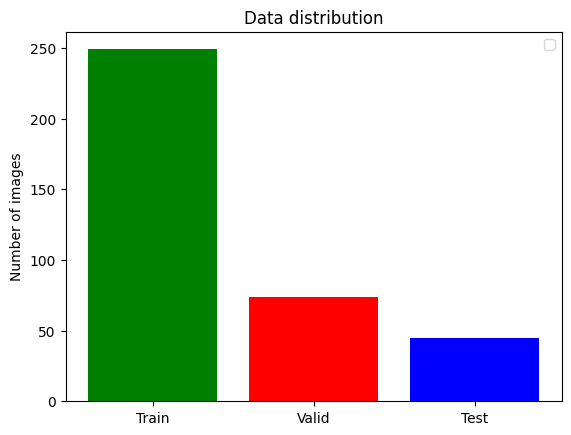

In [18]:
# show number of data for each dir
def showDataLayout():
    plt.bar(["Train", "Valid", "Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()

showDataLayout()

**Add callback for training process**

In [19]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

# Model Import

In [ ]:
# resnet_unet_model = keras.models.load_model('/content/ResUNET_model.h5',
#                                    custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
#                                                    "dice_coef": dice_coef,
#                                                    "precision": precision,
#                                                    "sensitivity":sensitivity,
#                                                    "specificity":specificity,
#                                                    "dice_coef_necrotic": dice_coef_necrotic,
#                                                    "dice_coef_edema": dice_coef_edema,
#                                                    "dice_coef_enhancing": dice_coef_enhancing
#                                                   }, compile=False)

unet_model = keras.models.load_model('/content/UNET_model.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

# wnet_model = keras.models.load_model('/content/ResUNET_model.h5',
#                                    custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
#                                                    "dice_coef": dice_coef,
#                                                    "precision": precision,
#                                                    "sensitivity":sensitivity,
#                                                    "specificity":specificity,
#                                                    "dice_coef_necrotic": dice_coef_necrotic,
#                                                    "dice_coef_edema": dice_coef_edema,
#                                                    "dice_coef_enhancing": dice_coef_enhancing
#                                                   }, compile=False)

inception_res_model = keras.models.load_model('/content/InceptionResNetV2.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)
wnet_model = keras.models.load_model('/content/WNET.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

# Prediction examples

In [20]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)


Predicting using Inceptio_Resnet_V2......
4/4 [==============================] - 0s 70ms/step


<Figure size 1800x5000 with 0 Axes>


 ------------------------------------------------------------------------------------------------------------------------------------------------------
Predicting using Ensemble Model......
4/4 [==============================] - 1s 195ms/step


<Figure size 1800x5000 with 0 Axes>

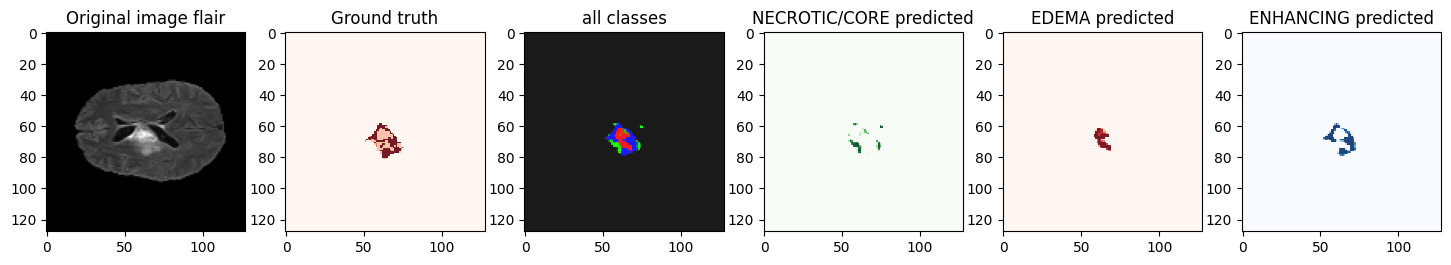


 ------------------------------------------------------------------------------------------------------------------------------------------------------


In [31]:
def predictByPath(case_path, case, model="Inception_ResNet_V2"):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()

 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    # if model == "unet":
    #   print("Predicting using UNET......")
    #   pred = unet_model.predict(X/np.max(X), verbose=1)
    # elif model == "wnet":
    #   print("Predicting using WNet Model......")
    #   pred = resnet_unet_model.predict(X/np.max(X), verbose=1)
    # elif model == "ensemble":
    #   print("Predicting using Ensemble Model......")
    #   pred = ensemble_model.predict(X/np.max(X), verbose=1)
    # elif model == "Inception_Resnet_v2":
    #   print("Predicting using IncResv222222222")
    #   pred = inception_res_model.predict(X/np.max(X), verbose=1)
    # else:
    #   print("Predicting using Inceptio_Resnet_V2......")
    #   pred = resnet_unet_model.predict(X/np.max(X), verbose=1)

    if model == "unet":
      print("Predicting using UNET......")
      pred = unet_model.predict(X/np.max(X), verbose=1)
    elif model == "wnet":
      print("Predicting using WNet Model......")
      pred = wnet_model.predict(X/np.max(X), verbose=1)
    elif model == "ensemble":
      print("Predicting using Ensemble Model......")
      pred = ensemble_model.predict(X/np.max(X), verbose=1)
    else:
      print("Predicting using Inceptio_Resnet_V2......")
      pred = inception_res_model.predict(X/np.max(X), verbose=1)

    return pred


def showPredictsById(case, start_slice = 60, model="Inception_ResNet_V2"):
    path = f"/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path, case, model)

    core = p[:,:,:,1]         # GREEN
    edema= p[:,:,:,2]         # RED
    enhancing = p[:,:,:,3]    # BLUE

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    # for i in range(6): # for each image, add brain background
    #     axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.9) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.9)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="Greens", interpolation='none', alpha=0.9)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="Reds", interpolation='none', alpha=0.9)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="Blues", interpolation='none', alpha=0.9)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    print(f"\n", "-" * 150)


# showPredictsById(case=test_ids[18][-3:], model="unet")
showPredictsById(case=test_ids[18][-3:],model = "Inception_Resnet_v2")
showPredictsById(case=test_ids[19][-3:], model="ensemble")
# showPredictsById(case=test_ids[3][-3:],model = "wnet")
# showPredictsById(case=test_ids[4][-3:])
# showPredictsById(case=test_ids[5][-3:])
# showPredictsById(case=test_ids[6][-3:])


case =  144
Predicting using Inceptio_Resnet_V2......
4/4 [==============================] - 0s 71ms/step
Predicting using UNET......
4/4 [==============================] - 1s 51ms/step
Predicting using Ensemble Model......
4/4 [==============================] - 1s 194ms/step
Predicting using Inceptio_Resnet_V2......
4/4 [==============================] - 0s 46ms/step


Text(0.5, 1.0, ' all classes \n Inception')

<Figure size 1000x1000 with 0 Axes>

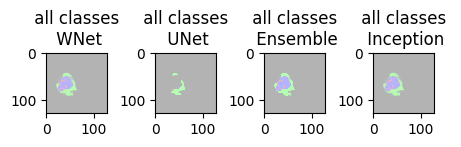

In [32]:
case = test_ids[18][-3:]
print("case = ", case)
start_slice = 60

path = f"/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}/"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
p = predictByPath(path, case)
p_unet = predictByPath(path, case, model="unet")
p_ensemble = predictByPath(path, case, model="ensemble")
p_inception = predictByPath(path, case, model="Inception_Resnet_v2")

core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]

# print(f" Core: {core}\n Edema: {edema}\n Enhancing: {enhancing}")

plt.figure(figsize=(10, 10))
f, axarr = plt.subplots(1, 4, figsize = (5, 50))
plt.subplots_adjust(wspace=0.8)

axarr[0].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
axarr[0].set_title(' all classes \n WNet')
axarr[1].imshow(p_unet[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
axarr[1].set_title(' all classes \n UNet')
axarr[2].imshow(p_ensemble[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
axarr[2].set_title(' all classes \n Ensemble')
axarr[3].imshow(p_inception[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
axarr[3].set_title(' all classes \n Inception')

In [33]:
print(p.shape)
# print(p)

(100, 128, 128, 4)


# Evaluation

Predicting using Inceptio_Resnet_V2......
4/4 [==============================] - 0s 72ms/step
Predicting using UNET......
4/4 [==============================] - 0s 55ms/step
Predicting using Ensemble Model......
4/4 [==============================] - 1s 206ms/step


<Figure size 2000x4000 with 0 Axes>

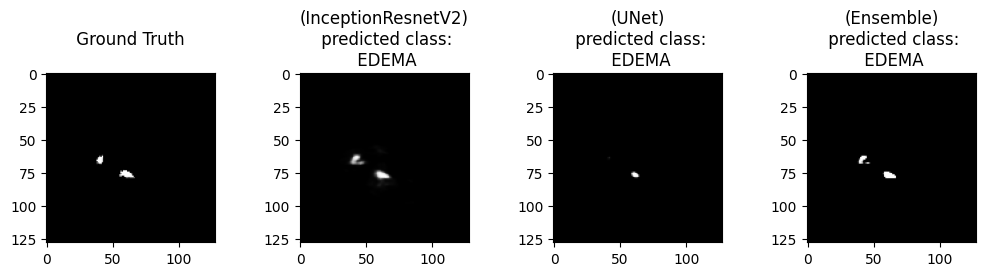

In [38]:
case = case=test_ids[33][-3:]
path = f"/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path, case)
p_unet = predictByPath(path, case, model="unet")
p_ensemble = predictByPath(path, case, model="ensemble")


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'


gt[gt != eval_class] = 1 # use only one class for per class evaluation

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
# p_wnet = predictByPath(path,case,model = "wnet")
plt.figure(figsize=(20, 40))
f, axarr = plt.subplots(1,4, figsize=(12, 4))
plt.subplots_adjust(wspace=0.5)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('\n Ground Truth \n')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'(InceptionResnetV2)\n predicted class:\n {SEGMENT_CLASSES[eval_class]}')
axarr[2].imshow(p_unet[i,:,:,eval_class], cmap="gray")
axarr[2].title.set_text(f'(UNet)\n predicted class:\n {SEGMENT_CLASSES[eval_class]}')
axarr[3].imshow(p_ensemble[i,:,:,eval_class], cmap="gray")
axarr[3].title.set_text(f'(Ensemble)\n predicted class:\n {SEGMENT_CLASSES[eval_class]}')
# axarr[4].imshow(p_wnet[i,:,:,eval_class], cmap="gray")
# axarr[4].title.set_text(f'(WNet)\n predicted class:\n {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [36]:
# Generate ROC curve
# generate_roc_curve(y_true, y_pred)

In [22]:
def calculateIoU(gtMask, predMask):
        # Calculate the true positives,
        # false positives, and false negatives
        tp = 0
        fp = 0
        fn = 0

        for i in range(len(gtMask)):
            for j in range(len(gtMask[0])):
                if gtMask[i][j] == 1 and predMask[i][j] == 1:
                    tp += 1
                elif gtMask[i][j] == 0 and predMask[i][j] == 1:
                    fp += 1
                elif gtMask[i][j] == 1 and predMask[i][j] == 0:
                    fn += 1

        # Calculate IoU
        iou = tp / (tp + fp + fn)

        return iou

# Ensembling

In [23]:
class AddWeighted(Layer):
    def __init__(self):
        super(AddWeighted, self).__init__()

    def call(self, inputs):
        return inputs[0] + inputs[1]

In [24]:
metric_names = ['loss', 'accuracy', 'recall' ,'mean_io_u', 'dice_coef', 'precision', 'sensitivity', 'specificity', 'dice_coef_necrotic', 'dice_coef_edema', 'dice_coef_enhancing']

# Ensemble Model: Unet + Inception_resnet_v2+Wnet

In [25]:
import numpy as np
import nibabel as nib
import cv2
import keras
from keras.layers import Input, Add
from keras.models import Model
import tensorflow as tf

# Custom objects for loading the models
custom_objects = {
    'accuracy': tf.keras.metrics.MeanIoU(num_classes=4),
    'dice_coef': dice_coef,
    'precision': precision,
    'sensitivity': sensitivity,
    'specificity': specificity,
    'dice_coef_necrotic': dice_coef_necrotic,
    'dice_coef_edema': dice_coef_edema,
    'dice_coef_enhancing': dice_coef_enhancing
}

# Function to clone a model and rename its layers
def clone_model_with_prefix(model, prefix):
    def clone_function(layer):
        layer_config = layer.get_config()
        layer_config['name'] = prefix + layer_config['name']
        return layer.__class__.from_config(layer_config)

    cloned_model = keras.models.clone_model(model, clone_function=clone_function)
    cloned_model._name = prefix + cloned_model.name  # Ensure the model name is unique
    return cloned_model

# Load the models with custom objects
inception_res_model = keras.models.load_model('/content/InceptionResNetV2.h5', custom_objects=custom_objects, compile=False)
unet_model = keras.models.load_model('/content/UNET_model.h5', custom_objects=custom_objects, compile=False)
wnet_model = keras.models.load_model('/content/WNET.h5', custom_objects=custom_objects, compile=False)

wnet_model = clone_model_with_prefix(wnet_model, 'wnet_')

def create_ensemble_model(unet_model, inception_res_model, wnet_model, n_classes=4):
    input_layer = Input(shape=(128, 128, 2), name='ensemble_input')
    pred_unet = unet_model(input_layer)
    pred_res_unet = inception_res_model(input_layer)
    pred_wnet = wnet_model(input_layer)

    # Define the weights for each model's predictions
    weight_unet = 0.7
    weight_res_unet = 11
    weight_wnet = 0.2

    # Weighted predictions
    weighted_preds = Add(name='weighted_predictions')([
        pred_unet * weight_unet,
        pred_res_unet * weight_res_unet,
        pred_wnet * weight_wnet
    ])

    output = keras.layers.Activation('softmax', name='ensemble_output')(weighted_preds)

    model = Model(inputs=input_layer, outputs=output, name='ensemble_model')
    return model

ensemble_model = create_ensemble_model(unet_model, inception_res_model, wnet_model)
ensemble_model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),
                       metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),recall, dice_coef,
                                  precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )

print("Evaluate on test data")
ensemble_model_results = ensemble_model.evaluate(test_generator, batch_size=100)

# Print the results with their respective metric names
metric_names = ['loss', 'accuracy', 'MeanIoU', 'recall', 'dice_coef', 'precision', 'sensitivity',
                'specificity', 'dice_coef_necrotic', 'dice_coef_edema', 'dice_coef_enhancing']

print("Test Results of Ensemble model:")
for name, result in zip(metric_names, ensemble_model_results):
    print(f"{name}: {result}")
    print("_" * 50)

Evaluate on test data
45/45 [==============================] - 58s 673ms/step - loss: 0.0370 - accuracy: 0.9937 - mean_io_u_4: 0.3756 - recall: 0.9935 - dice_coef: 0.6897 - precision: 0.9936 - sensitivity: 0.9935 - specificity: 0.9979 - dice_coef_necrotic: 0.6136 - dice_coef_edema: 0.7134 - dice_coef_enhancing: 0.6142
Test Results of Ensemble model:
loss: 0.03703831881284714
__________________________________________________
accuracy: 0.9936544895172119
__________________________________________________
MeanIoU: 0.37558281421661377
__________________________________________________
recall: 0.9934583902359009
__________________________________________________
dice_coef: 0.6897332072257996
__________________________________________________
precision: 0.9935979843139648
__________________________________________________
sensitivity: 0.9934583902359009
__________________________________________________
specificity: 0.9978651404380798
__________________________________________________
dice_

In [26]:
metric_names = ['loss', 'accuracy', 'recall' ,'mean_io_u_19', 'dice_coef', 'precision', 'sensitivity',
                'specificity', 'dice_coef_necrotic', 'dice_coef_edema', 'dice_coef_enhancing']

unet_model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),
                   metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),recall, dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the unet_model on the test data using `evaluate`
print("Evaluate on test data")
results_unet = unet_model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
# Print the results with their respective metric names
print("Test Results of UNet model:")
for name, result in zip(metric_names, results_unet):
    print(f"{name}: {result}")
    print("_" * 40)


print("_________________________________________________________________________________\n"*2)

inception_res_model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),
                          metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),recall, dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the resnet_unet_model on the test data using `evaluate`
print("Evaluate on test data")
results_resnet_unet = inception_res_model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("Test Results of Inception_Resnet_V2 model:")
for name, result in zip(metric_names, results_resnet_unet):
    print(f"{name}: {result}")
    print("_" * 40)

print("_________________________________________________________________________________\n"*2)

ensemble_model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),
                       metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),recall, dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the resnet_unet_model on the test data using `evaluate`
print("Evaluate on test data")
results_ensemble = ensemble_model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("Test Results of Ensemble model:")
for name, result in zip(metric_names, results_ensemble):
    print(f"{name}: {result}")
    print("_" * 40)



Evaluate on test data
45/45 [==============================] - 16s 297ms/step - loss: 0.2103 - accuracy: 0.9848 - mean_io_u_5: 0.4118 - recall: 0.9848 - dice_coef: 0.3666 - precision: 0.9848 - sensitivity: 0.9848 - specificity: 0.9949 - dice_coef_necrotic: 0.1199 - dice_coef_edema: 0.2203 - dice_coef_enhancing: 0.1056
Test Results of UNet model:
loss: 0.21031802892684937
________________________________________
accuracy: 0.9847949147224426
________________________________________
recall: 0.411816269159317
________________________________________
mean_io_u_19: 0.9847596287727356
________________________________________
dice_coef: 0.36656543612480164
________________________________________
precision: 0.9847776889801025
________________________________________
sensitivity: 0.9847596287727356
________________________________________
specificity: 0.9949262142181396
________________________________________
dice_coef_necrotic: 0.11989203840494156
________________________________________
dice

case:  144
4/4 [==============================] - 1s 216ms/step
(100, 128, 128, 4)
0.9999752 8.200338e-06
weighted_ensemble_prediction.shape: (100, 128, 128)
3 0


<Figure size 1800x5000 with 0 Axes>

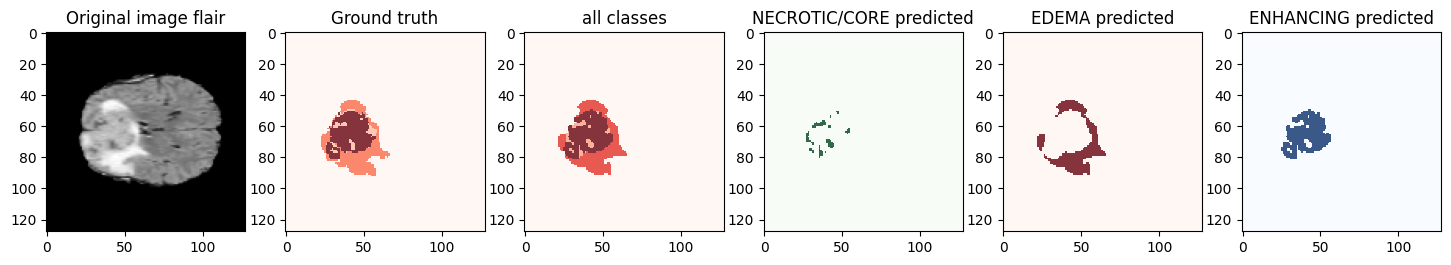


 ----------------------------------------------------------------------------------------------------


In [29]:
case_id = test_ids[18]
case = case_id[-3:]; print("case: ", case)
path = f"/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

vol_path_flair = os.path.join(path, f'BraTS20_Training_{case}_flair.nii')
flair = nib.load(vol_path_flair).get_fdata()

vol_path_ce = os.path.join(path, f'BraTS20_Training_{case}_t1ce.nii')
ce = nib.load(vol_path_ce).get_fdata()

for j in range(VOLUME_SLICES):
    X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

ensemble_pred = ensemble_model.predict(X / np.max(X))
print(ensemble_pred.shape)
print(np.max(ensemble_pred), np.min(ensemble_pred))
weighted_ensemble_prediction = np.argmax(ensemble_pred, axis=3); print("weighted_ensemble_prediction.shape:", weighted_ensemble_prediction.shape)
print(np.max(weighted_ensemble_prediction), np.min(weighted_ensemble_prediction))

# Plot Figure
plt.figure(figsize=(18, 50))
f, axarr = plt.subplots(1, 6, figsize=(18, 50))

# for i in range(6):  # for each image, add brain background
#     axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),
#                     cmap="gray", interpolation='none')

axarr[0].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),
                        cmap="gray")
axarr[0].title.set_text('Original image flair')
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE),
                             interpolation=cv2.INTER_NEAREST)
axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.8)  # ,alpha=0.3,cmap='Reds'
axarr[1].title.set_text('Ground truth')
axarr[2].imshow(weighted_ensemble_prediction[start_slice], cmap="Reds", interpolation='none', alpha=0.8)
axarr[2].title.set_text('all classes')
axarr[3].imshow(weighted_ensemble_prediction[start_slice] == 1, cmap="Greens", interpolation='none', alpha=0.8)
axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
axarr[4].imshow(weighted_ensemble_prediction[start_slice] == 2, cmap="Reds", interpolation='none', alpha=0.8)
axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
axarr[5].imshow(weighted_ensemble_prediction[start_slice] == 3, cmap="Blues", interpolation='none', alpha=0.8)
axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
plt.show()
print("\n" ,"-" * 100)

case:  148
weighted_ensemble_prediction.shape: (100, 128, 128)
________________________________________________________________
Case BraTS20_Training_148 - Weighted Ensemble
________________________________________________________________


<Figure size 1800x5000 with 0 Axes>

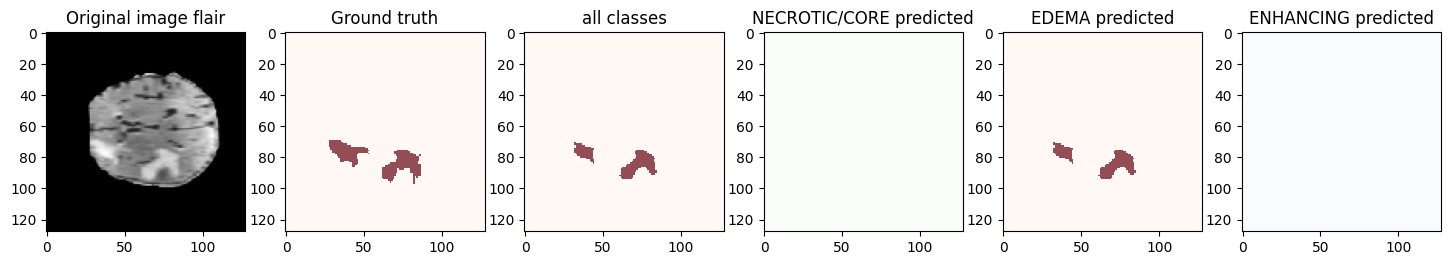


 ----------------------------------------------------------------------------------------------------
case:  106
weighted_ensemble_prediction.shape: (100, 128, 128)
________________________________________________________________
Case BraTS20_Training_106 - Weighted Ensemble
________________________________________________________________


<Figure size 1800x5000 with 0 Axes>

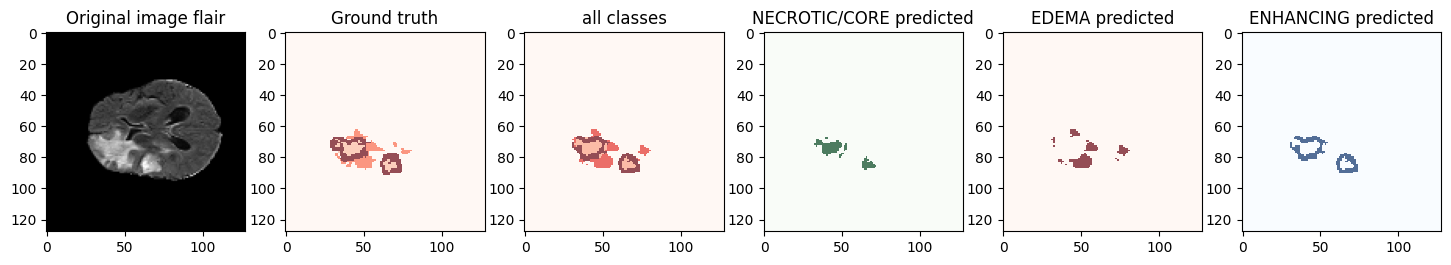


 ----------------------------------------------------------------------------------------------------
case:  090
weighted_ensemble_prediction.shape: (100, 128, 128)
________________________________________________________________
Case BraTS20_Training_090 - Weighted Ensemble
________________________________________________________________


<Figure size 1800x5000 with 0 Axes>

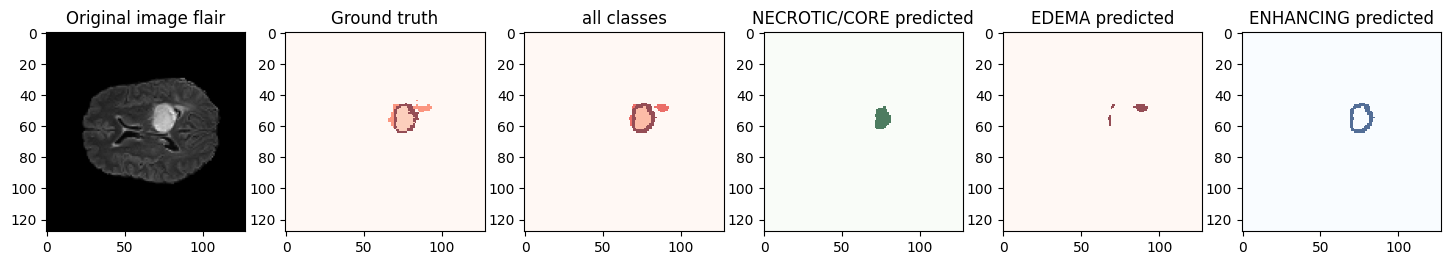


 ----------------------------------------------------------------------------------------------------
case:  144
weighted_ensemble_prediction.shape: (100, 128, 128)
________________________________________________________________
Case BraTS20_Training_144 - Weighted Ensemble
________________________________________________________________


<Figure size 1800x5000 with 0 Axes>

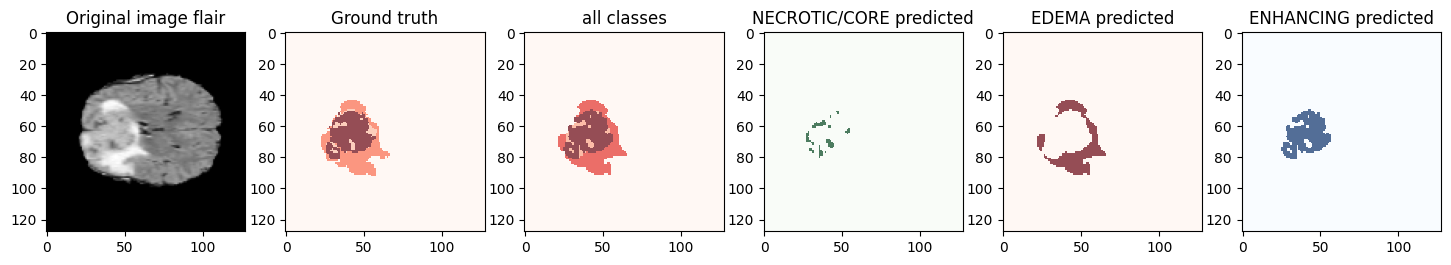


 ----------------------------------------------------------------------------------------------------
case:  022
weighted_ensemble_prediction.shape: (100, 128, 128)
________________________________________________________________
Case BraTS20_Training_022 - Weighted Ensemble
________________________________________________________________


<Figure size 1800x5000 with 0 Axes>

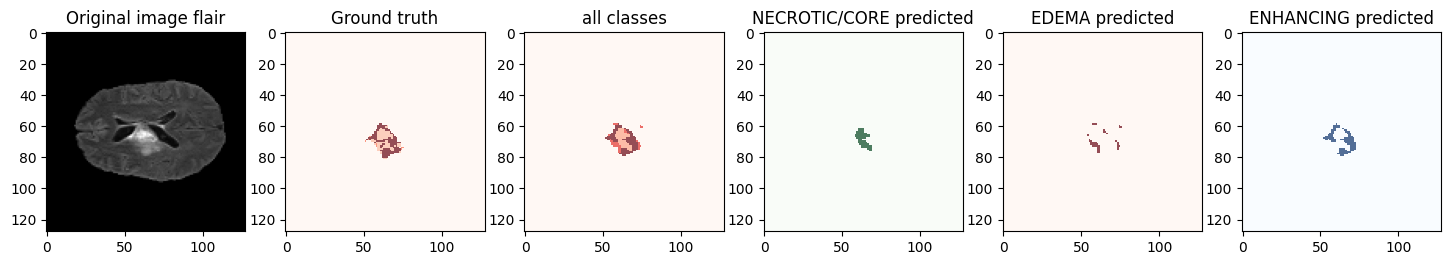


 ----------------------------------------------------------------------------------------------------


In [28]:
case_ids = test_ids[15:20]

for case_id in case_ids:
        case = case_id[-3:]; print("case: ", case)

        path = f"/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
        origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
        X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

        vol_path_flair = os.path.join(path, f'BraTS20_Training_{case}_flair.nii')
        flair = nib.load(vol_path_flair).get_fdata()

        vol_path_ce = os.path.join(path, f'BraTS20_Training_{case}_t1ce.nii')
        ce = nib.load(vol_path_ce).get_fdata()

        for j in range(VOLUME_SLICES):
            X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
            X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

        weighted_preds = ensemble_model.predict(X / np.max(X), verbose=0); #print("weighted_preds.shape:", weighted_preds.shape)
        weighted_ensemble_prediction = np.argmax(weighted_preds, axis=3); print("weighted_ensemble_prediction.shape:", weighted_ensemble_prediction.shape)

        start_slice = 60

        print("________________________________________________________________")
        print(f"Case {case_id} - Weighted Ensemble")

        gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
        curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE),
                             interpolation=cv2.INTER_NEAREST);
        # iou = calculateIoU(curr_gt, weighted_ensemble_prediction[60+22])
        # print('IOU Score for weighted average ensemble =', iou)
        print("________________________________________________________________")

        plt.figure(figsize=(18, 50))
        f, axarr = plt.subplots(1, 6, figsize=(18, 50))

        # for i in range(6):  # for each image, add brain background
        #     axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),
        #                     cmap="gray", interpolation='none')

        axarr[0].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),
                        cmap="gray")
        axarr[0].title.set_text('Original image flair')
        curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE),
                             interpolation=cv2.INTER_NEAREST)
        axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.7)  # ,alpha=0.3,cmap='Reds'
        axarr[1].title.set_text('Ground truth')
        axarr[2].imshow(weighted_ensemble_prediction[start_slice], cmap="Reds", interpolation='none', alpha=0.7)
        axarr[2].title.set_text('all classes')
        axarr[3].imshow(weighted_ensemble_prediction[start_slice] == 1, cmap="Greens", interpolation='none', alpha=0.7)
        axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
        axarr[4].imshow(weighted_ensemble_prediction[start_slice] == 2, cmap="Reds", interpolation='none', alpha=0.7)
        axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
        axarr[5].imshow(weighted_ensemble_prediction[start_slice] == 3, cmap="Blues", interpolation='none', alpha=0.7)
        axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
        plt.show()
        print("\n" ,"-" * 100)